In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.optimizers import Adam

In [2]:
df = pd.read_csv('spam.csv',encoding='latin-1')

In [4]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2938,ham,Are you ok. What happen to behave like this,NaN,NaN,NaN
1793,ham,You bad girl. I can still remember them,NaN,NaN,NaN
4006,ham,I'm reaching home in 5 min.,NaN,NaN,NaN
2449,ham,Then she dun believe wat?,NaN,NaN,NaN
2468,ham,Lol well don't do it without me. We could have...,NaN,NaN,NaN


In [5]:
df.shape

(5572, 5)

## 1. Data Cleaning

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [7]:
# drop last 3 cols
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [8]:
df.sample(5)

,v1,v2
3485,ham,"Yeah, probably earlier than that"
5151,ham,No problem with the renewal. I.ll do it right ...
4204,spam,IMPORTANT INFORMATION 4 ORANGE USER 0796XXXXXX...
5222,ham,5 nights...We nt staying at port step liao...T...
5536,ham,Aiyah ok wat as long as got improve can alread...


In [9]:
# renaming the cols
df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

,target,text
2715,ham,Cool. I am &lt;#&gt; inches long. hope you l...
4673,ham,I'm leaving my house now.
1995,ham,Shall i come to get pickle
338,ham,"Sorry, I'll call later"
4814,ham,ÌÏ no home work to do meh...


In [10]:
encoder = LabelEncoder()

In [11]:
df['target'] = encoder.fit_transform(df['target'])

In [12]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
# missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [14]:
# check for duplicate values
df.duplicated().sum()

403

In [15]:
# remove duplicates
df = df.drop_duplicates(keep='first')

In [16]:
df.duplicated().sum()

0

In [17]:
df.shape

(5169, 2)

## 2.EDA

In [18]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

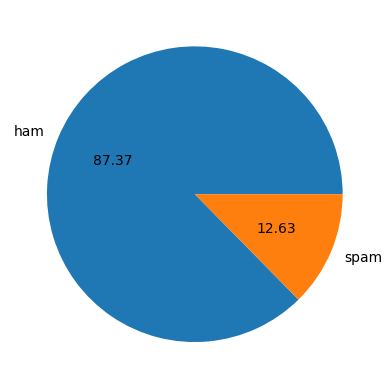

In [20]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [21]:
import nltk

In [22]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
df['num_characters'] = df['text'].apply(len)

In [25]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [26]:
# num of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [27]:
df.head()

,target,text,num_characters,num_words
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [28]:
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [29]:
df.head()

,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [30]:
df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [31]:
# ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [32]:
#spam
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


In [33]:
import seaborn as sns

<Axes: xlabel='num_characters', ylabel='Count'>

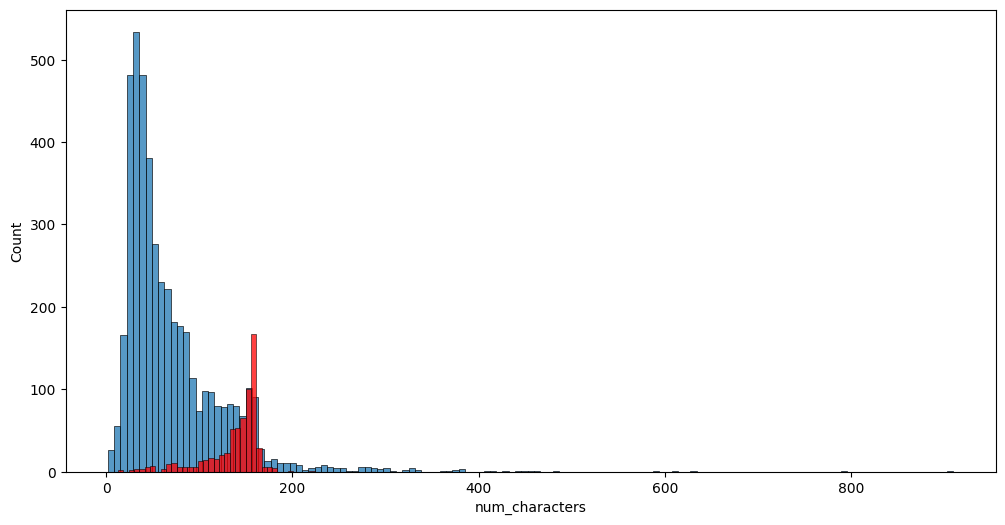

In [34]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

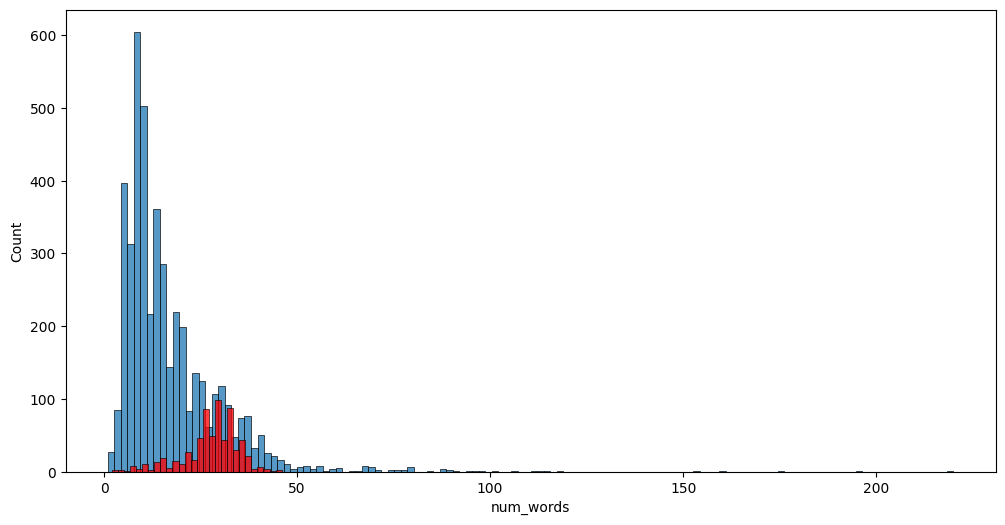

In [35]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'],color='red')

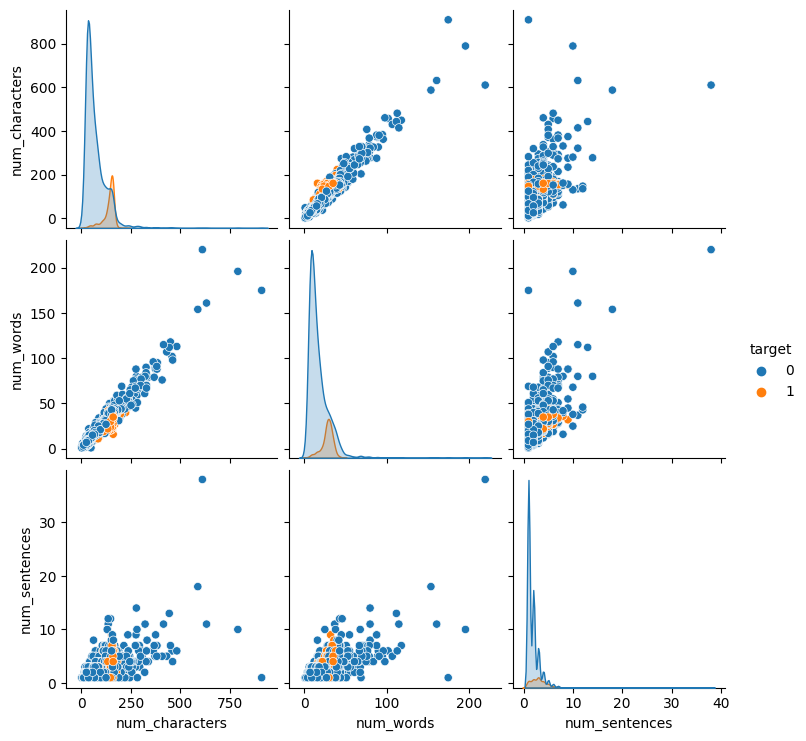

In [36]:
sns.pairplot(df,hue='target')

<ipython-input-37-8df7bcac526d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


<Axes: >

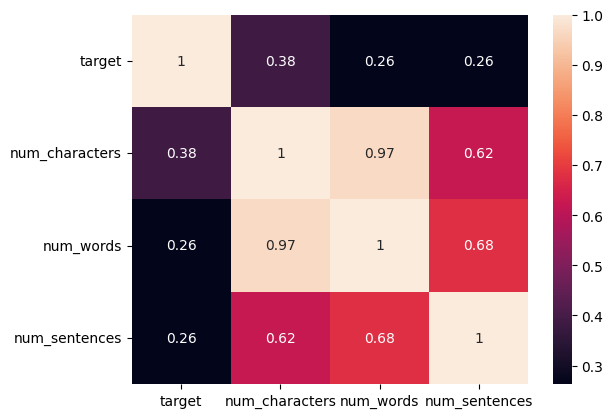

In [37]:
sns.heatmap(df.corr(),annot=True)

## 3. Data Preprocessing
- Lower case
- Tokenization
- Removing special characters
- Removing stop words and punctuation
- Stemming

In [38]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [39]:
ps = PorterStemmer()

In [40]:
def transform_text(text):
    text = text.lower()
    text = nltk.word_tokenize(text)

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)

    text = y[:]
    y.clear()

    for i in text:
        y.append(ps.stem(i))


    return " ".join(y)

In [41]:
transform_text("I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.")

'gon na home soon want talk stuff anymor tonight k cri enough today'

In [42]:
df['text'][10]

"I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today."

In [44]:
df['transformed_text'] = df['text'].apply(transform_text)

In [45]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [46]:
from wordcloud import WordCloud
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

In [47]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

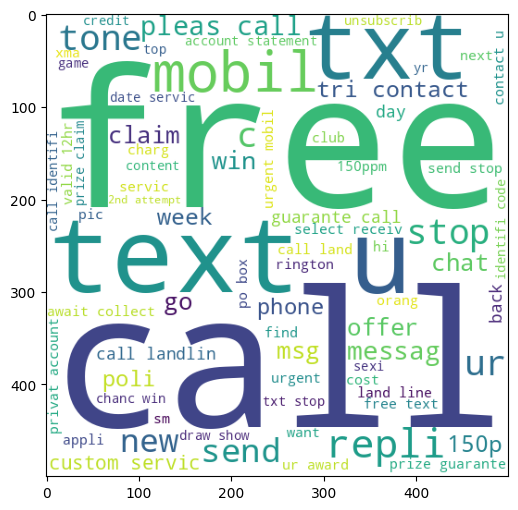

In [48]:
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

In [49]:
ham_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

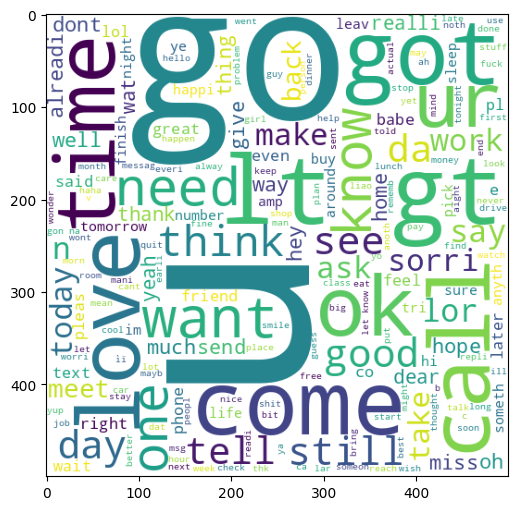

In [50]:
plt.figure(figsize=(15,6))
plt.imshow(ham_wc)

In [51]:
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [52]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)


In [53]:
len(spam_corpus)

9939

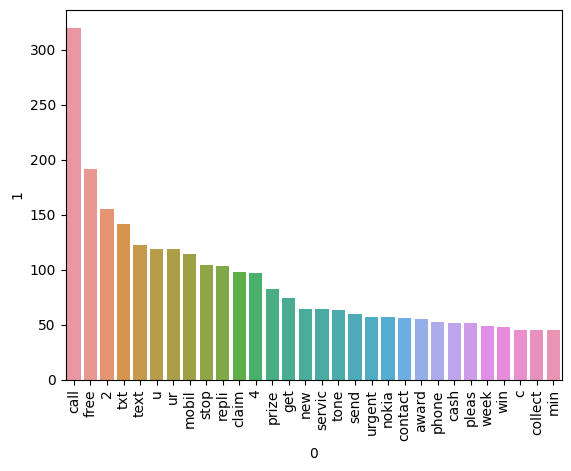

In [54]:
from collections import Counter
spam_counter = pd.DataFrame(Counter(spam_corpus).most_common(30))
sns.barplot(x=spam_counter[0], y=spam_counter[1])
plt.xticks(rotation='vertical')
plt.show()


In [55]:
ham_corpus = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    for word in msg.split():
        ham_corpus.append(word)

In [56]:
len(ham_corpus)

35404

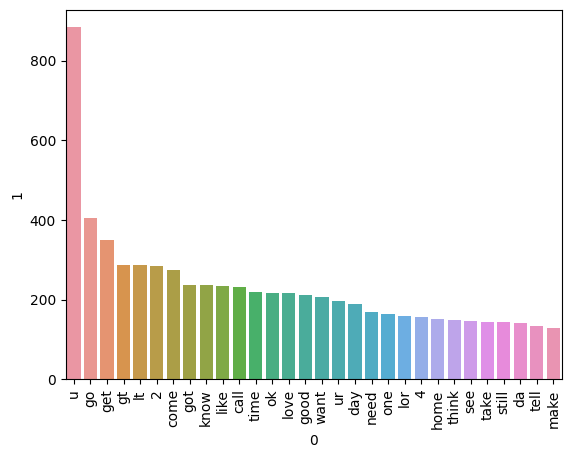

In [57]:
from collections import Counter
ham_counter = pd.DataFrame(Counter(ham_corpus).most_common(30))
sns.barplot(x=ham_counter[0], y=ham_counter[1])
plt.xticks(rotation='vertical')
plt.show()


In [58]:
# Text Vectorization
# using Bag of Words
df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


## 4. Model Building

In [64]:

max_features = 1500
maxlen = 200

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(df['transformed_text'])
sequences = tokenizer.texts_to_sequences(df['transformed_text'])

data = pad_sequences(sequences, maxlen=maxlen)

# Split data into training and test sets
labels = np.asarray(df['target'])  # 1 for spam and 0 for not spam
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

In [68]:
# Define the LSTM model
model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(LSTM(64, dropout=0.3))
model.add(Dense(1, activation='sigmoid'))

In [69]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [71]:
# Train the model
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
130/130 [==============================] - 30s 214ms/step - loss: 0.2102 - accuracy: 0.9328 - val_loss: 0.0696 - val_accuracy: 0.9778
Epoch 2/10
130/130 [==============================] - 27s 208ms/step - loss: 0.0527 - accuracy: 0.9838 - val_loss: 0.0675 - val_accuracy: 0.9787
Epoch 3/10
130/130 [==============================] - 25s 195ms/step - loss: 0.0269 - accuracy: 0.9925 - val_loss: 0.0734 - val_accuracy: 0.9807
Epoch 4/10
130/130 [==============================] - 27s 210ms/step - loss: 0.0173 - accuracy: 0.9971 - val_loss: 0.0740 - val_accuracy: 0.9797
Epoch 5/10
130/130 [==============================] - 27s 212ms/step - loss: 0.0103 - accuracy: 0.9981 - val_loss: 0.0928 - val_accuracy: 0.9768
Epoch 6/10
130/130 [==============================] - 27s 211ms/step - loss: 0.0108 - accuracy: 0.9983 - val_loss: 0.0886 - val_accuracy: 0.9816
Epoch 7/10
130/130 [==============================] - 27s 209ms/step - loss: 0.0121 - accuracy: 0.9966 - val_loss: 0.0862 - val_ac

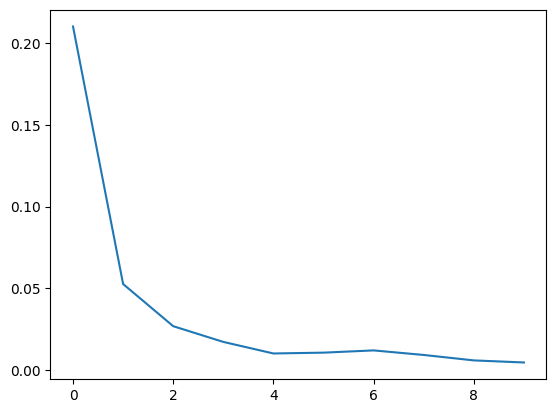

In [72]:
plt.plot(history.history['loss'])


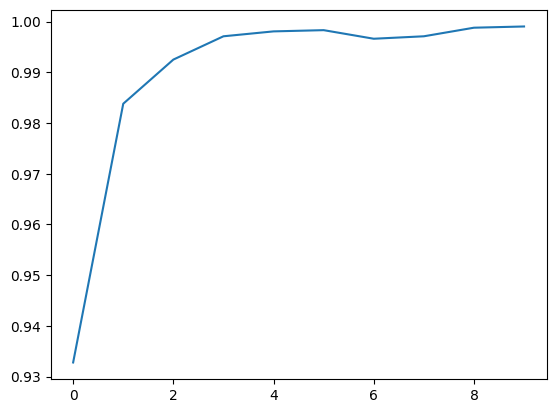

In [74]:
plt.plot(history.history['accuracy'])


In [76]:
# Make predictions
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)

33/33 [==============================] - 4s 83ms/step


In [77]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9748549323017408
Precision: 0.9107142857142857
Recall: 0.864406779661017
F1 Score: 0.8869565217391304


**CNN Model**

In [86]:
from keras.layers import *

In [90]:
model = Sequential()

# Embedding layer
model.add(Embedding(max_features, 128, input_length=maxlen))

# Convolution layer
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))

# Pooling layer
model.add(MaxPooling1D())

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [91]:
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

In [92]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
130/130 [==============================] - 23s 155ms/step - loss: 0.2538 - accuracy: 0.9168 - val_loss: 0.0764 - val_accuracy: 0.9739
Epoch 2/10
130/130 [==============================] - 16s 120ms/step - loss: 0.0514 - accuracy: 0.9855 - val_loss: 0.0691 - val_accuracy: 0.9797
Epoch 3/10
130/130 [==============================] - 16s 123ms/step - loss: 0.0232 - accuracy: 0.9944 - val_loss: 0.0799 - val_accuracy: 0.9787
Epoch 4/10
130/130 [==============================] - 16s 123ms/step - loss: 0.0146 - accuracy: 0.9971 - val_loss: 0.0973 - val_accuracy: 0.9787
Epoch 5/10
130/130 [==============================] - 16s 123ms/step - loss: 0.0102 - accuracy: 0.9978 - val_loss: 0.1209 - val_accuracy: 0.9797
Epoch 6/10
130/130 [==============================] - 16s 124ms/step - loss: 0.0074 - accuracy: 0.9981 - val_loss: 0.1224 - val_accuracy: 0.9778
Epoch 7/10
130/130 [==============================] - 19s 145ms/step - loss: 0.0064 - accuracy: 0.9985 - val_loss: 0.1437 - val_ac

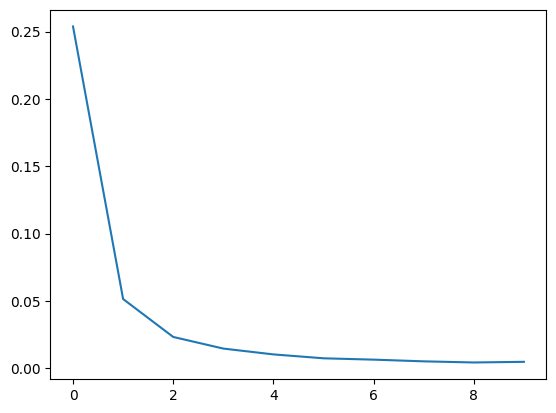

In [97]:
plt.plot(history.history['loss'])

In [98]:
# Make predictions
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5)

33/33 [==============================] - 1s 24ms/step


In [99]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9777562862669246
Precision: 0.9279279279279279
Recall: 0.8728813559322034
F1 Score: 0.8995633187772925
